# Social and Environmental

- Data Cleaning
- Descriptive Statistics
- Grouping by Proxies
- Selecting Specific Items

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns
import time
from datetime import datetime
from datetime import timezone

%matplotlib inline

In [2]:
# Reading the data from social and environmental revisions and items
revisions = pd.read_csv('/Users/tushi/PRJ/WikidataParsing/topics/data_with_revisions/social_environmental_revisions.csv')
items = pd.read_csv('/Users/tushi/PRJ/WikidataParsing/topics/data/social_environmental.csv')

In [3]:
print("Number of Revisions in Social and Environmental Dataset")
print(revisions.shape)
print("Number of Wikidata Items in Social and Environmental Dataset")
print(items.shape)

Number of Revisions in Social and Environmental Dataset
(4883145, 12)
Number of Wikidata Items in Social and Environmental Dataset
(801486, 3)


# Data Cleaning

In [3]:
# Dropping unecessary columns from the revisions dataframe
rev = revisions.drop(['pageid', 'type', 'editentity', 'parentid'], axis=1)

In [4]:
# Method to assign edit types to each revision by using the revision comment
def get_edit_type(comment):
    # Decoding the comment from a bytes object to a string
    # c = comment.decode("utf-8").lower()
    
    # Converting the comment to lowercase
    c = comment.lower()
    edit_type = '' 
    
    if c == '':
        return edit_type
    
    if "|" in c:
        # Comments which have |
        # Extracting initial edit summary and removing /*
        cc = c.split("|")[0].replace("/* ", "")
        if 'undo' in cc:
            edit_type = 'undo'
            return edit_type
        elif 'restore' in cc:
            edit_type = 'restore'
            return edit_type
        elif 'wbsetclaimvalue' in cc:
            edit_type = 'set'
            return edit_type
        elif 'wbsetlabeldescriptionaliases' in cc:
            edit_type = 'set'
            return edit_type
        elif 'wbcreateredirect' in cc:
            edit_type = 'create'
            return edit_type
        elif 'merge' in cc:
            edit_type = 'merge'
            return edit_type
        elif '-' in cc:
            ccc = cc.split("-")[1]
            if 'create' in ccc:
                edit_type = 'create'
                return edit_type
            elif 'add' in ccc:
                edit_type = 'add'
                return edit_type
            elif 'set' in ccc:
                edit_type = 'set'
                return edit_type
            elif 'update' in ccc:
                edit_type = 'update'
                return edit_type
            elif 'remove' in ccc:
                edit_type = 'remove'
                return edit_type
    if 'revert' in c: 
        edit_type = 'revert'
        return edit_type  
    elif 'protect' in c:
        edit_type = 'protect'
        return edit_type  
    elif 'undid' in c:
        edit_type = 'undo'
        return edit_type      
    return edit_type
        

In [5]:
# Assigning edit types to each revision
rev['type'] = [get_edit_type(comment) for comment in rev['comment']]

In [6]:
rev.shape

(4883145, 9)

In [7]:
# Removing revisions with empty types - empty comments or edge cases
to_remove = rev[rev['type'] == ''].index
rev = rev.drop(to_remove)

In [8]:
# Reading csv with bot names scraped from Wikidata
bots = pd.read_csv('/Users/tushi/PRJ/WikidataParsing/wikidata_bots.csv')

In [9]:
# Method to assign user types to revisions
# 3 types: Registered, Anonymous, Bot
def get_user_type(user):
    
    # Remove preceeding b from storing as a bytes object
    # Replace ' with empty character
    u = user[1:].replace("'", "")
    
    user_type = ''
    
    if u == "":
        user_type = 'Anonymous'
        return user_type
    elif u in bots.values:
        user_type = 'Bot'
        return user_type
    else: 
        user_type = 'Registered'
        return user_type
    return user_type
    

In [10]:
# Assigning user types to revisions
rev['usertype'] = [get_user_type(user) for user in rev['username']]

In [11]:
# Need to recalculate editcount for the items
# Drop old editcount column
rev = rev.drop(['editscount'], axis=1)

In [12]:
editscount = rev['qid'].value_counts()

In [13]:
editscount.describe()

count    799329.000000
mean          6.079448
std          13.261592
min           1.000000
25%           1.000000
50%           2.000000
75%           5.000000
max         917.000000
Name: qid, dtype: float64

In [14]:
# Converting to a dataframe so that it can be compared/merged with original dataframe
df_editscount = pd.DataFrame({'qid':editscount.index, 'editscount':editscount.values})

In [15]:
print('Items with No of Edits = 1')
print(len(df_editscount[df_editscount['editscount'] == 1]))

print('Items with No of Edits = 2')
print(len(df_editscount[df_editscount['editscount'] == 2]))

print('Items with No of Edits = 3')
print(len(df_editscount[df_editscount['editscount'] == 3]))

print('Items with No of Edits = 4')
print(len(df_editscount[df_editscount['editscount'] == 4]))

print('Items with No of Edits = 5')
print(len(df_editscount[df_editscount['editscount'] == 5]))

print('Items with No of Edits <= 5')
print(len(df_editscount[df_editscount['editscount'] <= 5]))

Items with No of Edits = 1
305661
Items with No of Edits = 2
196500
Items with No of Edits = 3
69624
Items with No of Edits = 4
27647
Items with No of Edits = 5
30991
Items with No of Edits <= 5
630423


In [16]:
# Removing items with editscount <= 5 
to_remove = df_editscount[df_editscount['editscount'] <= 5].index
df_editscount = df_editscount.drop(to_remove)

In [17]:
df_editscount.shape

(168906, 2)

In [18]:
# Removing all items with editscount <= 5 from revisions dataset
# Removing by finding intersection on qid between bot sets
rev = pd.merge(rev, df_editscount, how='inner', on=['qid'])

In [19]:
# Converting the timestamps to datetime object
rev['timestamp'] = pd.to_datetime(rev.timestamp, format='%Y-%m-%d %H:%M:%S')

# Converting to datetime leaves the dates in form '2016-10-12 14:37:53+00:00'
# Formatting timestamp to remove +00:00
rev['timestamp'] = rev['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')

# strftime() returns a string object
# Converting back to datetime
rev['timestamp'] = pd.to_datetime(rev.timestamp, format='%Y-%m-%d %H:%M:%S')

In [20]:
rev.dtypes

Unnamed: 0             int64
qid                   object
revisionid           float64
timestamp     datetime64[ns]
comment               object
userid               float64
username              object
type                  object
usertype              object
editscount             int64
dtype: object

In [21]:
print(df_editscount.head())
print(df_editscount[df_editscount['qid'] == 'Q52'])
print(df_editscount[df_editscount['qid'] == 'Q2013'])

        qid  editscount
0  Q3642765         917
1  Q3964154         743
2  Q4504204         726
3   Q534197         702
4     Q1085         657
     qid  editscount
366  Q52         126
       qid  editscount
828  Q2013          91


In [22]:
# Removing wikipedia item from editscount and rev
to_remove = df_editscount[df_editscount['qid'] == 'Q52'].index
df_editscount = df_editscount.drop(to_remove)
# Removing item from dataset of revisions
to_remove_from_rev = rev[rev['qid'] == 'Q52'].index
rev = rev.drop(to_remove_from_rev)

In [23]:
# Removing wikidata item from editscount and rev
to_remove = df_editscount[df_editscount['qid'] == 'Q2013'].index
df_editscount = df_editscount.drop(to_remove)
# Removing item from dataset of revisions
to_remove_from_rev = rev[rev['qid'] == 'Q2013'].index
rev = rev.drop(to_remove_from_rev)

In [24]:
print(df_editscount.head())
print(df_editscount[df_editscount['qid'] == 'Q52'])
print(df_editscount[df_editscount['qid'] == 'Q2013'])

        qid  editscount
0  Q3642765         917
1  Q3964154         743
2  Q4504204         726
3   Q534197         702
4     Q1085         657
Empty DataFrame
Columns: [qid, editscount]
Index: []
Empty DataFrame
Columns: [qid, editscount]
Index: []


In [25]:
print("Number of Revisions in Social & Environmental Dataset after Data Cleaning")
print(rev.shape)
print("Number of Wikidata Items in Social & Environmental Dataset after Data Cleaning")
social_environmental_items = rev['qid'].value_counts()
print(social_environmental_items.shape)

Number of Revisions in Social & Environmental Dataset after Data Cleaning
(3686186, 10)
Number of Wikidata Items in Social & Environmental Dataset after Data Cleaning
(168904,)


# Descriptive Statistics

In [26]:
print(social_environmental_items.describe().astype(int))

count    168904
mean         21
std          22
min           6
25%           7
50%          15
75%          19
max         917
Name: qid, dtype: int32


In [27]:
# Converting a series to a dataframe
se_items = pd.DataFrame({'type':social_environmental_items.index, 'count':social_environmental_items.values})

In [28]:
# Items between the median and 75th percentile
print(se_items[(se_items['count'] >= 15) & (se_items['count'] < 19)])
# Items in the top 25% of the dataset
print(se_items[se_items['count'] >= 19])
# Items below median that is items that fall in the fist 50%
print(se_items[se_items['count'] < 15])
# Items that form the low 25% of the dataset
print(se_items[se_items['count'] < 7])
# Items that are part of 75% of the dataset
print(se_items[se_items['count'] < 19])

            type  count
44862   Q4130288     18
44863   Q4177256     18
44864   Q4277372     18
44865  Q14621424     18
44866  Q13664580     18
...          ...    ...
92663    Q235389     15
92664  Q15343435     15
92665  Q18779621     15
92666  Q18767576     15
92667  Q18644057     15

[47806 rows x 2 columns]
           type  count
0      Q3642765    917
1      Q3964154    743
2      Q4504204    726
3       Q534197    702
4         Q1085    657
...         ...    ...
44857  Q4135830     19
44858  Q4257844     19
44859  Q1820843     19
44860  Q4087802     19
44861  Q4501933     19

[44862 rows x 2 columns]
             type  count
92668   Q16021967     14
92669   Q18769459     14
92670    Q3888543     14
92671   Q14620364     14
92672      Q59745     14
...           ...    ...
168899  Q27888563      6
168900  Q23012939      6
168901  Q20229607      6
168902  Q20140799      6
168903  Q20224027      6

[76236 rows x 2 columns]
             type  count
149629   Q1637534      6
149630  

# Statistics for Proxies

In [29]:
# Counting the value of the number of proxies that exist in the dataset
type_stats = rev['type'].value_counts()

In [30]:
# Converting a series to a Dataframe
type_s = pd.DataFrame({'type':type_stats.index, 'count':type_stats.values})
ts = type_s.set_index('type')
print(ts)

           count
type            
add      2328942
update    625793
remove    382363
create    288059
set        56300
undo        2564
merge       1285
revert       578
restore      296
protect        6


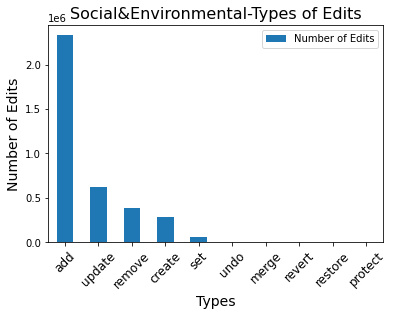

In [33]:
# Plotting the statistics for the proxies in the dataset
ax = ts.plot.bar()

plt.title('Social&Environmental-Types of Edits', fontsize=16)
plt.xlabel('Types', fontsize=14)
plt.ylabel('Number of Edits', fontsize=14)

plt.xticks(rotation=45, fontsize=12)
ax.legend(['Number of Edits'])

plt.show()

In [34]:
# Extracting select proxies: remove, restore, revert, merge, undo, protect
controversial_proxies = ts.iloc[[2, 5, 6, 7, 8, 9]]
# print(controversial_proxies)

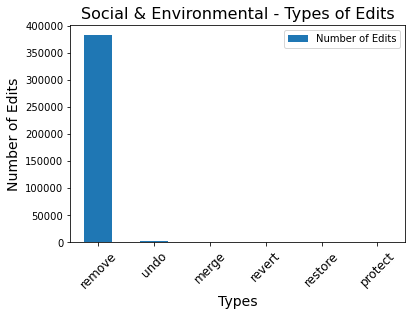

In [35]:
# Plotting select proxies
ax = controversial_proxies.plot.bar()

plt.title('Social & Environmental - Types of Edits', fontsize=16)
plt.xlabel('Types', fontsize=14)
plt.ylabel('Number of Edits', fontsize=14)

plt.xticks(rotation=45, fontsize=12)
ax.legend(['Number of Edits'])

plt.show()

In [36]:
# Extracting select proxies: restore, revert, merge, undo, protect
controversial_proxies_without_remove = ts.iloc[[5, 6, 7, 8, 9]]
print(controversial_proxies_without_remove)

         count
type          
undo      2564
merge     1285
revert     578
restore    296
protect      6


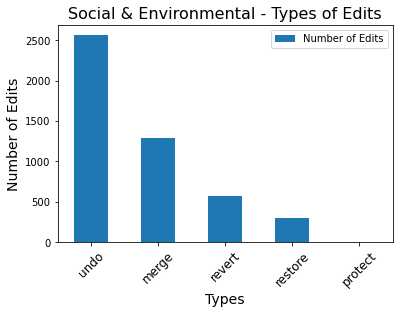

In [37]:
# Plotting select proxies without remove
ax = controversial_proxies_without_remove.plot.bar()

plt.title('Social & Environmental - Types of Edits', fontsize=16)
plt.xlabel('Types', fontsize=14)
plt.ylabel('Number of Edits', fontsize=14)

plt.xticks(rotation=45, fontsize=12)
ax.legend(['Number of Edits'])

plt.show()

# Statistics for No of Edits

In [38]:
no_of_edits = social_environmental_items.to_numpy()

(array([8.5527e+04, 5.0282e+04, 3.8880e+03, 1.1540e+03, 6.8000e+02,
        1.0590e+03, 2.4301e+04, 4.0800e+02, 4.5800e+02, 4.9000e+02,
        1.1200e+02, 8.6000e+01, 8.3000e+01, 5.9000e+01, 3.3000e+01,
        3.3000e+01, 3.1000e+01, 2.5000e+01, 2.6000e+01, 2.3000e+01,
        1.8000e+01, 1.1000e+01, 1.1000e+01, 1.3000e+01, 9.0000e+00,
        4.0000e+00, 6.0000e+00, 5.0000e+00, 8.0000e+00, 6.0000e+00,
        2.0000e+00, 7.0000e+00, 4.0000e+00, 1.0000e+00, 5.0000e+00,
        1.0000e+00, 2.0000e+00, 4.0000e+00, 5.0000e+00, 1.0000e+00,
        1.0000e+00, 3.0000e+00, 1.0000e+00, 0.0000e+00, 3.0000e+00,
        3.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.00

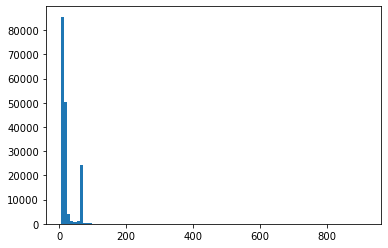

In [39]:
# Exploring distribution of number of edits
plt.hist(no_of_edits, 100)

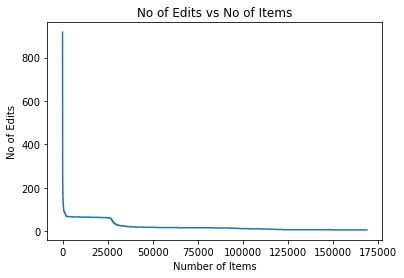

In [40]:
# Plotting No of Edits for the Items in the dataset 
# Line Plot

plt.plot(no_of_edits)

plt.title("No of Edits vs No of Items")
plt.xlabel("Number of Items")
plt.ylabel("No of Edits")

plt.show()

# Grouping by Proxies

In [41]:
reverts = rev["type"].str.contains("revert")
revert_edits = reverts.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [42]:
merges = rev["type"].str.contains("merge")
merge_edits = merges.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [43]:
undos = rev["type"].str.contains("undo")
undo_edits = undos.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [44]:
restores = rev["type"].str.contains("restore")
restore_edits = restores.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [45]:
protects = rev["type"].str.contains("protect")
protect_edits = protects.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [46]:
removes = rev["type"].str.contains("remove")
remove_edits = removes.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [47]:
# Creating a dataframe which will contain qids for items and no of each proxy
proxies = pd.DataFrame({'revert': revert_edits, 'merge': merge_edits, 'undo': undo_edits, 'restore': restore_edits, 
                        'protect': protect_edits, 'remove': remove_edits})

In [48]:
proxies = proxies.reset_index()

In [49]:
proxies.columns

Index(['qid', 'revert', 'merge', 'undo', 'restore', 'protect', 'remove'], dtype='object')

In [50]:
df_editscount.columns

Index(['qid', 'editscount'], dtype='object')

In [51]:
# Adding editscount for each item 
proxies = pd.merge(proxies, df_editscount, how='inner', on=['qid'])

In [52]:
# Counting the number of users per item that is userscount
rev_users = rev.groupby('qid')['username'].nunique()
# Converting to a dataframe so that it can be compared/merged 
df_userscount = pd.DataFrame({'qid':rev_users.index, 'userscount':rev_users.values})

In [53]:
# Adding userscount for each item 
proxies = pd.merge(proxies, df_userscount, how='inner', on=['qid'])

In [54]:
proxies.describe()

,revert,merge,undo,restore,protect,remove,editscount,userscount
count,168904.000000,168904.000000,168904.000000,168904.000000,168904.000000,168904.000000,168904.000000,168904.000000
mean,0.003422,0.007608,0.015180,0.001752,0.000036,2.263789,21.824149,2.078287
std,0.086986,0.091859,0.161568,0.052384,0.005960,2.770455,22.658121,1.563479
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.000000,2.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,19.000000,3.000000
max,7.000000,4.000000,8.000000,6.000000,1.000000,137.000000,917.000000,51.000000


Text(0, 0.5, 'No of Edits')

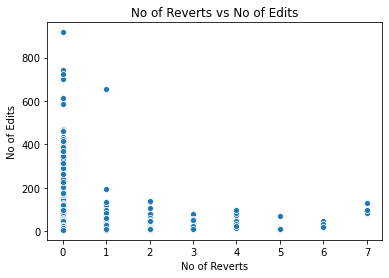

In [55]:
ax = sns.scatterplot(x="revert", y="editscount", data=proxies)
ax.set_title("No of Reverts vs No of Edits")
ax.set_xlabel("No of Reverts")
ax.set_ylabel("No of Edits")

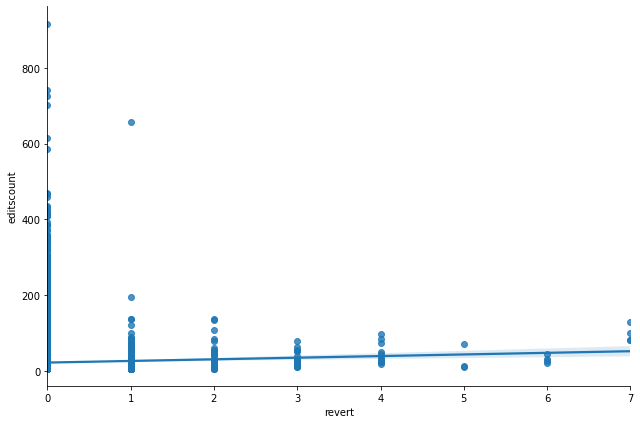

In [56]:
sns.lmplot(x="revert", y="editscount", data=proxies, height=6, aspect=1.5)

In [57]:
corr= proxies.corr()
corr

,revert,merge,undo,restore,protect,remove,editscount,userscount
revert,1.000000,0.026380,0.153436,0.289731,0.148224,-0.004827,0.016463,0.242033
merge,0.026380,1.000000,0.019744,0.058749,0.010320,-0.023287,-0.033307,0.098789
undo,0.153436,0.019744,1.000000,0.126271,0.067072,-0.057780,-0.028763,0.130437
restore,0.289731,0.058749,0.126271,1.000000,0.151508,0.015866,0.018501,0.164084
protect,0.148224,0.010320,0.067072,0.151508,1.000000,-0.000926,0.010919,0.076580
remove,-0.004827,-0.023287,-0.057780,0.015866,-0.000926,1.000000,-0.072862,-0.266698
editscount,0.016463,-0.033307,-0.028763,0.018501,0.010919,-0.072862,1.000000,-0.118266
userscount,0.242033,0.098789,0.130437,0.164084,0.076580,-0.266698,-0.118266,1.000000


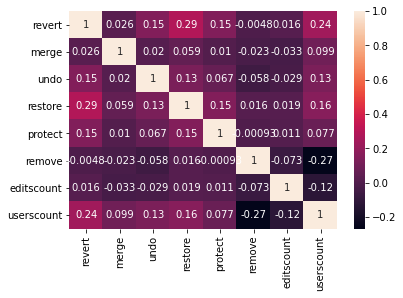

In [58]:
sns.heatmap(corr, annot=True)

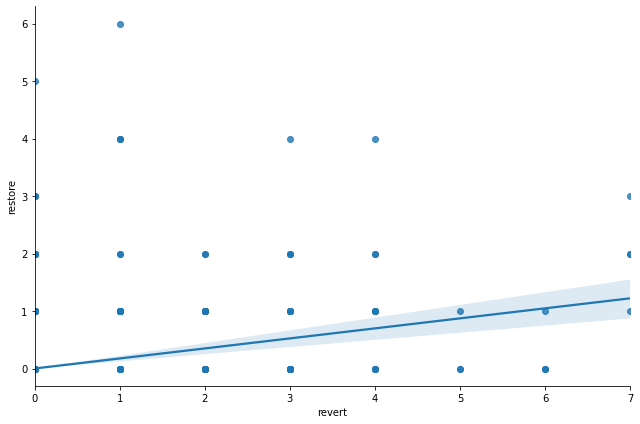

In [59]:
# restore and revert have positive correlation
sns.lmplot(x="revert", y="restore", data=proxies, height=6, aspect=1.5)

Text(0, 0.5, 'No of Edits')

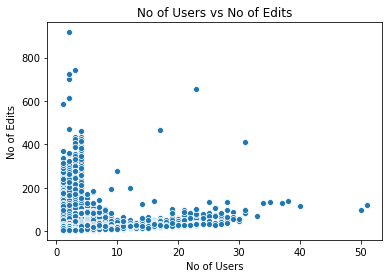

In [61]:
# userscount and editscount have negative correlation 
ax = sns.scatterplot(x="userscount", y="editscount", data=proxies)
ax.set_title("No of Users vs No of Edits")
ax.set_xlabel("No of Users")
ax.set_ylabel("No of Edits")

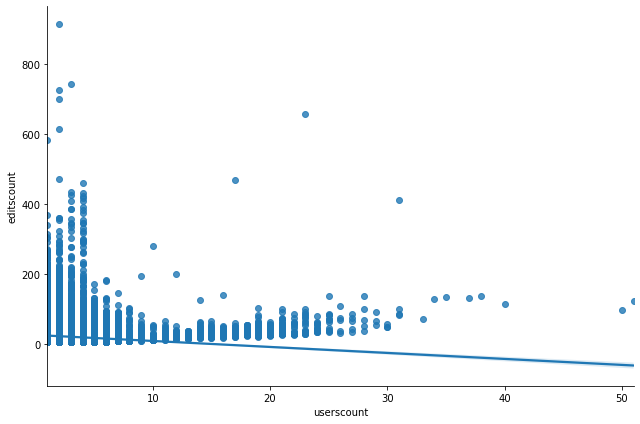

In [62]:
sns.lmplot(x="userscount", y="editscount", data=proxies, height=6, aspect=1.5)

In [63]:
# Removing items with 0 reverts, merges, undos, restores, removes, protects
to_remove = proxies[(proxies['revert'] == 0) & (proxies['merge'] == 0) & (proxies['undo'] == 0) & (proxies['restore'] == 0) & 
                   (proxies['remove'] == 0) & (proxies['protect'] == 0)].index
proxies = proxies.drop(to_remove)

In [64]:
proxies.shape

(83083, 9)

In [65]:
# Items which only have edits under remove and are 0 for the remaining proxies
proxies[(proxies['revert'] == 0) & (proxies['merge'] == 0) & (proxies['undo'] == 0) & (proxies['restore'] == 0)]

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
9,Q2125493,0,0,0,0,0,1,9,4
11,Q2126102,0,0,0,0,0,1,6,2
12,Q2126280,0,0,0,0,0,1,6,3
13,Q2126516,0,0,0,0,0,8,42,3
21,Q2129957,0,0,0,0,0,1,10,4
...,...,...,...,...,...,...,...,...,...
168808,Q28063830,0,0,0,0,0,1,28,2
168810,Q28064887,0,0,0,0,0,1,9,3
168815,Q28065753,0,0,0,0,0,1,19,2
168821,Q28071100,0,0,0,0,0,1,6,1


In [66]:
# Removing items with only edits under remove
to_remove = proxies[(proxies['revert'] == 0) & (proxies['merge'] == 0) & (proxies['undo'] == 0) & (proxies['restore'] == 0)].index
proxies_without_remove = proxies.drop(to_remove)

In [67]:
proxies_without_remove.shape

(3418, 9)

In [68]:
corr = proxies_without_remove.corr()
corr

,revert,merge,undo,restore,protect,remove,editscount,userscount
revert,1.000000,-0.167130,-0.035068,0.241622,0.142430,0.069701,0.239487,0.426074
merge,-0.167130,1.000000,-0.577295,-0.094867,-0.016630,0.092105,-0.060178,-0.065581
undo,-0.035068,-0.577295,1.000000,-0.035212,0.052852,-0.095122,0.019958,-0.026202
restore,0.241622,-0.094867,-0.035212,1.000000,0.145986,0.161662,0.237781,0.262590
protect,0.142430,-0.016630,0.052852,0.145986,1.000000,0.009187,0.101189,0.151253
remove,0.069701,0.092105,-0.095122,0.161662,0.009187,1.000000,0.621805,0.171016
editscount,0.239487,-0.060178,0.019958,0.237781,0.101189,0.621805,1.000000,0.537223
userscount,0.426074,-0.065581,-0.026202,0.262590,0.151253,0.171016,0.537223,1.000000


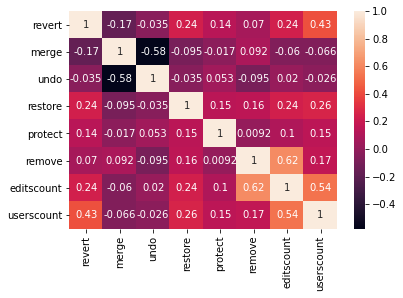

In [69]:
sns.heatmap(corr, annot=True)

# Top 20

## Top 20 Reverts

In [70]:
top20_reverts = proxies_without_remove.nlargest(20, 'revert')

In [71]:
top20_reverts

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
3977,Q29,7,0,8,3,0,5,130,37
4001,Q77,7,0,2,2,0,0,82,23
4007,Q96,7,0,4,1,0,4,82,31
4167,Q801,7,0,3,2,0,6,99,28
4074,Q355,6,0,3,1,0,4,45,19
5052,Q8452,6,0,0,0,0,6,27,7
5350,Q12204,6,0,1,0,0,1,32,11
72117,Q183130,6,0,0,0,0,0,21,7
3786,Q2758894,5,0,0,0,0,0,10,4
4064,Q298,5,0,0,1,0,2,70,21


In [72]:
revert_item_labels = ['Spain', 'Uruguay', 'Mexico', 'Israel', 'Facebook',
                     'abortion', 'tuberculosis', 'gastritis', '48, XXXX', 'Chile', 
                     'Aztec', 'England', 'Paris', 'Peru', 'Venezuela', 
                     'Madrid', 'Sunni Islam', 'The Chainsmokers', 'human papillomavirus infection', 'Vietnamese Wikipedia']

# Inserting item labels into revert proxies dataframe
top20_reverts.insert(1, "label", revert_item_labels, True)

In [73]:
top20_reverts

,qid,label,revert,merge,undo,restore,protect,remove,editscount,userscount
3977,Q29,Spain,7,0,8,3,0,5,130,37
4001,Q77,Uruguay,7,0,2,2,0,0,82,23
4007,Q96,Mexico,7,0,4,1,0,4,82,31
4167,Q801,Israel,7,0,3,2,0,6,99,28
4074,Q355,Facebook,6,0,3,1,0,4,45,19
5052,Q8452,abortion,6,0,0,0,0,6,27,7
5350,Q12204,tuberculosis,6,0,1,0,0,1,32,11
72117,Q183130,gastritis,6,0,0,0,0,0,21,7
3786,Q2758894,"48, XXXX",5,0,0,0,0,0,10,4
4064,Q298,Chile,5,0,0,1,0,2,70,21


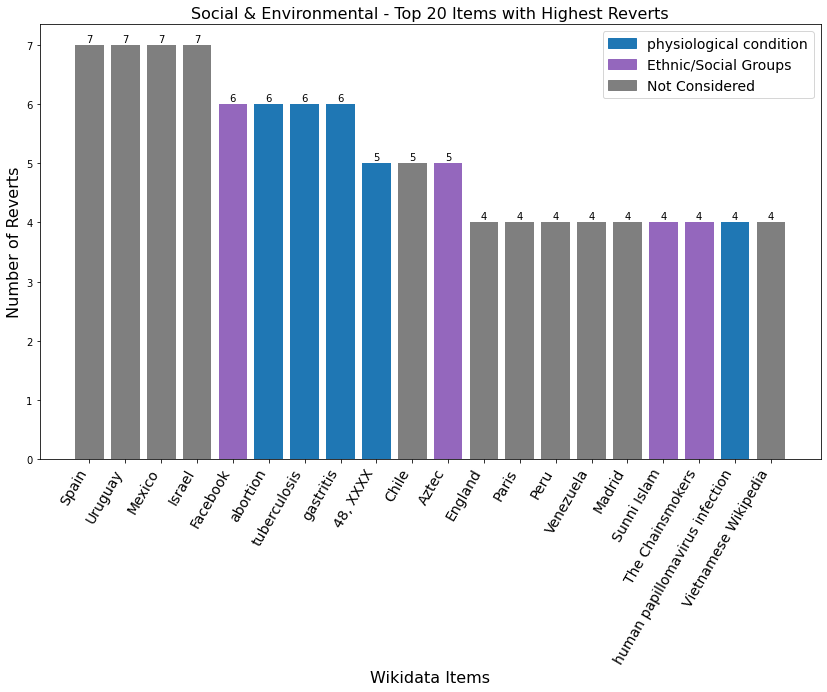

In [74]:
f, ax = plt.subplots(figsize=(14,8))

for i, r in enumerate(top20_reverts['revert']):
    ax.text(i, r+0.05, str(r), horizontalalignment='center')

colours = ['tab:gray', 'tab:gray', 'tab:gray', 'tab:gray', 'tab:purple',
           'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:gray',
           'tab:purple', 'tab:gray', 'tab:gray', 'tab:gray', 'tab:gray',
           'tab:gray', 'tab:purple', 'tab:purple', 'tab:blue', 'tab:gray']

phys_condition = mpatches.Patch(color='tab:blue', label='physiological condition')
social = mpatches.Patch(color='tab:purple', label='Ethnic/Social Groups')
not_considered = mpatches.Patch(color='tab:gray', label='Not Considered')

plt.legend(handles=[phys_condition, social, not_considered], fontsize=14)

plt.bar(top20_reverts['label'], top20_reverts['revert'], color=colours)

plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Reverts", fontsize=16)
plt.title("Social & Environmental - Top 20 Items with Highest Reverts", fontsize=16)
plt.show()

## Top 20 Merges

In [75]:
top20_merges = proxies_without_remove.nlargest(20, 'merge')

In [76]:
top20_merges

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
34963,Q13202722,0,4,0,0,0,0,10,4
156132,Q20571352,0,4,0,1,0,2,13,5
70375,Q25945398,0,3,0,0,0,0,6,3
78304,Q394129,0,3,0,0,0,0,11,2
92981,Q1151300,0,3,0,0,0,0,7,3
96729,Q1818778,0,3,0,0,0,14,28,8
156131,Q20571325,0,3,0,0,0,2,9,4
2595,Q2550468,0,2,0,0,0,2,11,2
2909,Q2604568,1,2,0,0,0,0,6,3
3526,Q2705394,0,2,0,1,0,6,20,4


In [77]:
merge_item_labels = ['permanent duplicate item-France', 'permanent duplicate item-Turkey', 'template-Internet Movie Database', 'psychomotor agitation', 'autoimmune lymphoproliferative syndrome',
                     'Tultepec', 'permanent duplicate item-USA', 'Nicolás Ruiz', 'Nagarote', 'Yermakovo', 
                     'Wijnbergshofje', 'Kuala Lumpur', 'Lhasa', 'Firmo', 'Mohammed VI', 
                     'Opfikon', 'dysentery', 'Frymburk', 'occupational disease', 'bacterial meningitis']

# Inserting item labels into merge proxies dataframe
top20_merges.insert(1, "label", merge_item_labels, True)

In [78]:
top20_merges

,qid,label,revert,merge,undo,restore,protect,remove,editscount,userscount
34963,Q13202722,permanent duplicate item-France,0,4,0,0,0,0,10,4
156132,Q20571352,permanent duplicate item-Turkey,0,4,0,1,0,2,13,5
70375,Q25945398,template-Internet Movie Database,0,3,0,0,0,0,6,3
78304,Q394129,psychomotor agitation,0,3,0,0,0,0,11,2
92981,Q1151300,autoimmune lymphoproliferative syndrome,0,3,0,0,0,0,7,3
96729,Q1818778,Tultepec,0,3,0,0,0,14,28,8
156131,Q20571325,permanent duplicate item-USA,0,3,0,0,0,2,9,4
2595,Q2550468,Nicolás Ruiz,0,2,0,0,0,2,11,2
2909,Q2604568,Nagarote,1,2,0,0,0,0,6,3
3526,Q2705394,Yermakovo,0,2,0,1,0,6,20,4


Text(0.5, 1.0, 'Social & Environmental - Top 20 Items with Highest Merges')

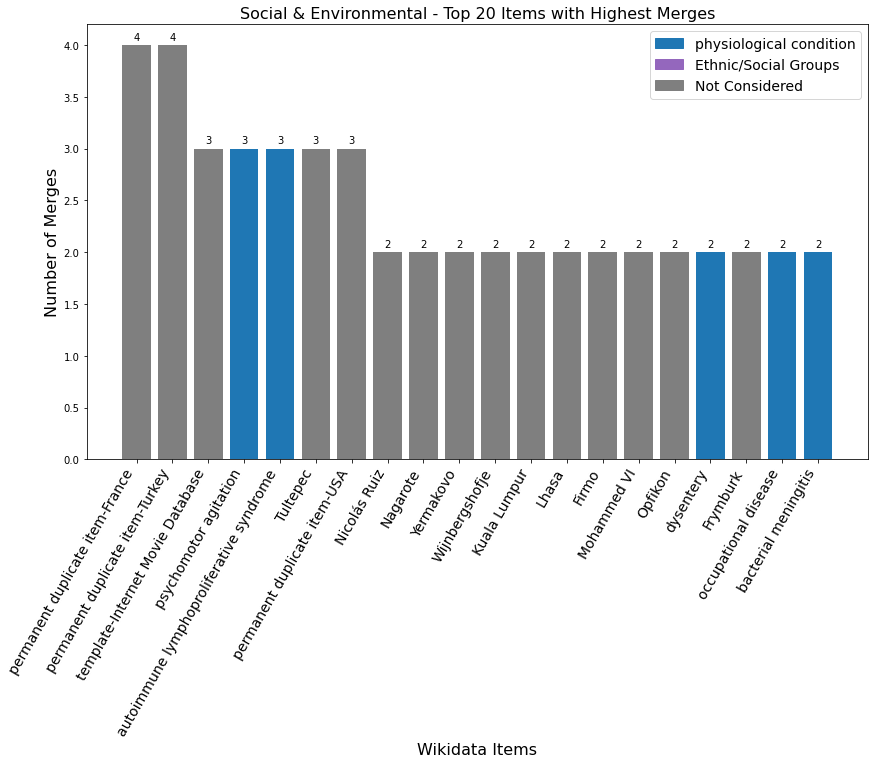

In [79]:
f, ax = plt.subplots(figsize=(14,8))

for i, r in enumerate(top20_merges['merge']):
    ax.text(i, r+0.05, str(r), horizontalalignment='center')
    

colours = ['tab:gray', 'tab:gray', 'tab:gray', 'tab:blue', 'tab:blue',
           'tab:gray', 'tab:gray', 'tab:gray', 'tab:gray', 'tab:gray',
           'tab:gray', 'tab:gray', 'tab:gray', 'tab:gray', 'tab:gray',
           'tab:gray', 'tab:blue', 'tab:gray', 'tab:blue', 'tab:blue']

phys_condition = mpatches.Patch(color='tab:blue', label='physiological condition')
social = mpatches.Patch(color='tab:purple', label='Ethnic/Social Groups')
not_considered = mpatches.Patch(color='tab:gray', label='Not Considered')

plt.legend(handles=[phys_condition, social, not_considered], fontsize=14)

plt.bar(top20_merges['label'], top20_merges['merge'], color=colours)
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Merges", fontsize=16)
plt.title("Social & Environmental - Top 20 Items with Highest Merges", fontsize=16)

## Top 20 Undos

In [80]:
top20_undos = proxies_without_remove.nlargest(20, 'undo')

In [81]:
top20_undos

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
3977,Q29,7,0,8,3,0,5,130,37
3978,Q30,1,1,6,4,1,5,122,51
8566,Q54898,0,0,6,0,0,0,15,4
83618,Q894081,0,0,6,0,0,0,16,3
95581,Q1640713,0,0,6,0,0,0,17,4
4020,Q183,0,0,5,0,0,14,115,40
12402,Q181754,1,0,5,0,0,1,20,8
32248,Q4795478,1,0,5,0,0,0,8,3
2308,Q2514944,0,0,4,0,0,0,10,2
4007,Q96,7,0,4,1,0,4,82,31


In [82]:
undo_item_labels = ['Spain', 'United States of America', 'San Cristóbal de La Laguna', 'Chorley', 'Hyndburn',
                     'Germany', 'heart failure', 'Aroer', 'Bacup', 'Mexico', 
                     'Monaco', 'Venezuela', 'Madrid', 'Kramatorsk', 'Rossendale', 
                     'Carnforth', 'Skelmersdale', 'Wigan', 'West Lancashire', 'Bolton']

# Inserting item labels into undo proxies dataframe
top20_undos.insert(1, "label", undo_item_labels, True)

In [83]:
top20_undos

,qid,label,revert,merge,undo,restore,protect,remove,editscount,userscount
3977,Q29,Spain,7,0,8,3,0,5,130,37
3978,Q30,United States of America,1,1,6,4,1,5,122,51
8566,Q54898,San Cristóbal de La Laguna,0,0,6,0,0,0,15,4
83618,Q894081,Chorley,0,0,6,0,0,0,16,3
95581,Q1640713,Hyndburn,0,0,6,0,0,0,17,4
4020,Q183,Germany,0,0,5,0,0,14,115,40
12402,Q181754,heart failure,1,0,5,0,0,1,20,8
32248,Q4795478,Aroer,1,0,5,0,0,0,8,3
2308,Q2514944,Bacup,0,0,4,0,0,0,10,2
4007,Q96,Mexico,7,0,4,1,0,4,82,31


Text(0.5, 1.0, 'Social & Environmental - Top 20 Items with Highest Undos')

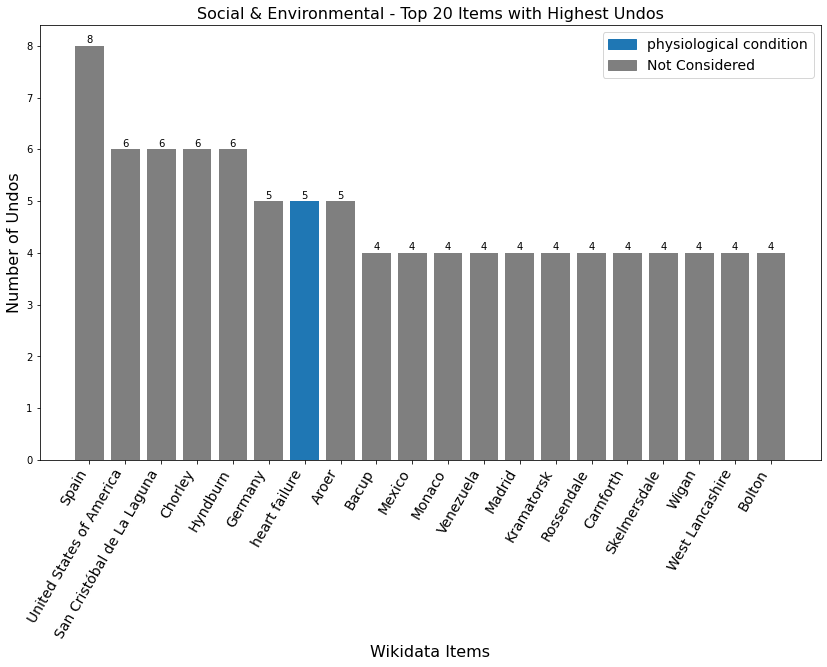

In [84]:
f, ax = plt.subplots(figsize=(14,8))

for i, r in enumerate(top20_undos['undo']):
    ax.text(i, r+0.05, str(r), horizontalalignment='center')
    
colours = ['tab:gray', 'tab:gray', 'tab:gray', 'tab:gray', 'tab:gray',
           'tab:gray', 'tab:blue', 'tab:gray', 'tab:gray', 'tab:gray',
           'tab:gray', 'tab:gray', 'tab:gray', 'tab:gray', 'tab:gray',
           'tab:gray', 'tab:gray', 'tab:gray', 'tab:gray', 'tab:gray']

phys_condition = mpatches.Patch(color='tab:blue', label='physiological condition')
not_considered = mpatches.Patch(color='tab:gray', label='Not Considered')

plt.legend(handles=[phys_condition, not_considered], fontsize=14)

plt.bar(top20_undos['label'], top20_undos['undo'], color=colours)
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Undos", fontsize=16)
plt.title("Social & Environmental - Top 20 Items with Highest Undos", fontsize=16)

## Top 20 Restores

In [85]:
top20_restores = proxies_without_remove.nlargest(20, 'restore')

In [86]:
top20_restores

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
114329,Q4580256,1,0,0,6,0,13,30,13
98346,Q2045165,0,0,0,5,0,0,6,2
3978,Q30,1,1,6,4,1,5,122,51
4085,Q414,3,0,0,4,0,3,80,24
4135,Q717,4,0,4,4,0,2,85,27
5049,Q8385,1,0,0,4,0,38,195,9
12107,Q174684,1,0,3,4,0,0,32,16
3977,Q29,7,0,8,3,0,5,130,37
11684,Q158119,0,0,3,3,0,2,31,17
34240,Q12031431,0,0,0,3,0,0,8,3


In [87]:
restore_item_labels = ['Project:Administrators\' noticeboard', 'Pyershamayski District', 'United States of America', 'Argentina', 'Venezuela',
                     'Ostrava', 'Tuzla', 'Spain', 'Ramallah', 'Krasovice',
                     'no label', 'Uruguay', 'Paris', 'Russia', 'Colombia', 
                     'Israel', 'Hamburg', 'Manila', 'Tokyo', 'Barcelona']

# Inserting item labels into restore proxies dataframe
top20_restores.insert(1, "label", restore_item_labels, True)

In [88]:
top20_restores

,qid,label,revert,merge,undo,restore,protect,remove,editscount,userscount
114329,Q4580256,Project:Administrators' noticeboard,1,0,0,6,0,13,30,13
98346,Q2045165,Pyershamayski District,0,0,0,5,0,0,6,2
3978,Q30,United States of America,1,1,6,4,1,5,122,51
4085,Q414,Argentina,3,0,0,4,0,3,80,24
4135,Q717,Venezuela,4,0,4,4,0,2,85,27
5049,Q8385,Ostrava,1,0,0,4,0,38,195,9
12107,Q174684,Tuzla,1,0,3,4,0,0,32,16
3977,Q29,Spain,7,0,8,3,0,5,130,37
11684,Q158119,Ramallah,0,0,3,3,0,2,31,17
34240,Q12031431,Krasovice,0,0,0,3,0,0,8,3


Text(0.5, 1.0, 'Social & Environmental- Top 20 Items with Highest Restores')

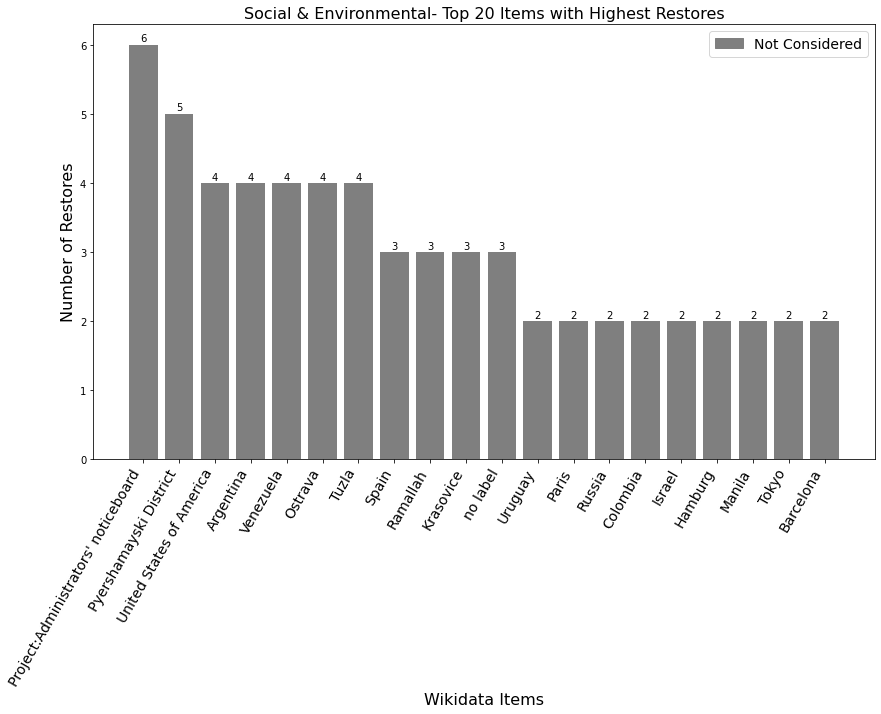

In [90]:
f, ax = plt.subplots(figsize=(14,8))

for i, r in enumerate(top20_restores['restore']):
    ax.text(i, r+0.05, str(r), horizontalalignment='center')

colours = ['tab:gray', 'tab:gray', 'tab:gray', 'tab:gray', 'tab:gray',
           'tab:gray', 'tab:gray', 'tab:gray', 'tab:gray', 'tab:gray',
           'tab:gray', 'tab:gray', 'tab:gray', 'tab:gray', 'tab:gray',
           'tab:gray', 'tab:gray', 'tab:gray', 'tab:gray', 'tab:gray']

not_considered = mpatches.Patch(color='tab:gray', label='Not Considered')

plt.legend(handles=[not_considered], fontsize=14)

plt.bar(top20_restores['label'], top20_restores['restore'], color=colours)
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Restores", fontsize=16)
plt.title("Social & Environmental- Top 20 Items with Highest Restores", fontsize=16)

## Top 20 Edits

In [91]:
top20_edits = proxies_without_remove.nlargest(20, 'editscount')

In [92]:
top20_edits

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
4280,Q1085,1,0,0,1,0,137,657,23
4116,Q656,0,0,1,0,0,7,413,31
5537,Q14960,0,0,1,0,0,59,279,10
5049,Q8385,1,0,0,4,0,38,195,9
80357,Q756617,0,1,2,0,0,9,139,16
4013,Q142,2,0,3,0,0,5,137,38
4017,Q159,1,0,3,2,0,7,136,28
4043,Q230,1,0,0,0,0,7,136,25
3992,Q55,2,0,0,1,0,8,135,35
3977,Q29,7,0,8,3,0,5,130,37


In [93]:
edit_item_labels = ['Prague', 'Saint Petersburg', 'Brno', 'Ostrava', 'Kingdom of Denmark',
                     'France', 'Russia', 'Georgia', 'Netherlands', 'Spain',
                     'Denmark', 'House of Zhu', 'United States of America', 'Palana Village', 'Germany', 
                     'Saudi Arabia', 'Hong Kong', 'Albania', 'India', 'Israel']

# Inserting item labels into edit proxies dataframe
top20_edits.insert(1, "label", edit_item_labels, True)

In [112]:
top20_edits

,qid,label,revert,merge,undo,restore,protect,remove,editscount,userscount
4280,Q1085,Prague,1,0,0,1,0,137,657,23
4116,Q656,Saint Petersburg,0,0,1,0,0,7,413,31
5537,Q14960,Brno,0,0,1,0,0,59,279,10
5049,Q8385,Ostrava,1,0,0,4,0,38,195,9
80357,Q756617,Kingdom of Denmark,0,1,2,0,0,9,139,16
4013,Q142,France,2,0,3,0,0,5,137,38
4017,Q159,Russia,1,0,3,2,0,7,136,28
4043,Q230,Georgia,1,0,0,0,0,7,136,25
3992,Q55,Netherlands,2,0,0,1,0,8,135,35
3977,Q29,Spain,7,0,8,3,0,5,130,37


Text(0.5, 1.0, 'Social & Environmental - Top 20 Items with Highest Edits')

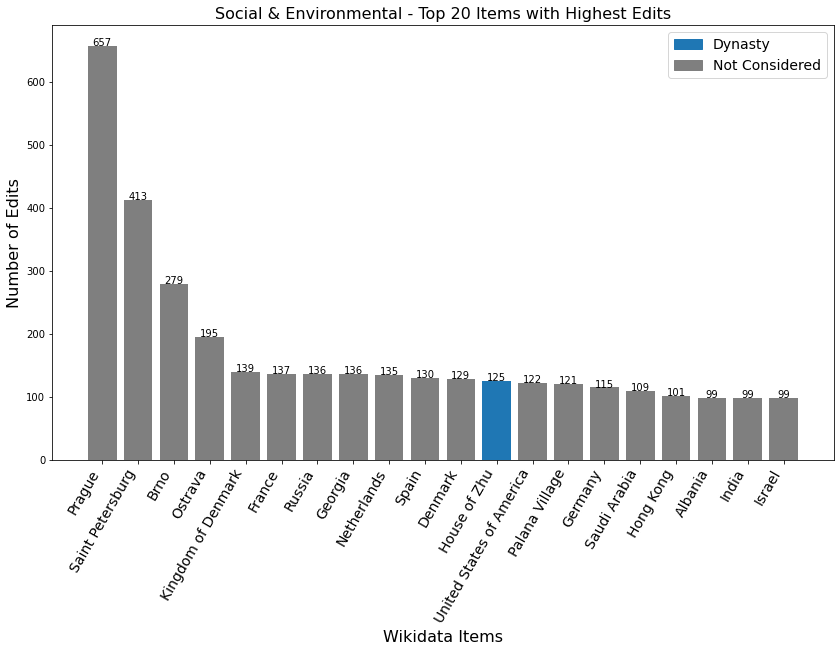

In [95]:
f, ax = plt.subplots(figsize=(14,8))

for i, r in enumerate(top20_edits['editscount']):
    ax.text(i, r+0.05, str(r), horizontalalignment='center')


colours = ['tab:gray', 'tab:gray', 'tab:gray', 'tab:gray', 'tab:gray',
           'tab:gray', 'tab:gray', 'tab:gray', 'tab:gray', 'tab:gray',
           'tab:gray', 'tab:blue', 'tab:gray', 'tab:gray', 'tab:gray',
           'tab:gray', 'tab:gray', 'tab:gray', 'tab:gray', 'tab:gray']

dynasty = mpatches.Patch(color='tab:blue', label='Dynasty')
not_considered = mpatches.Patch(color='tab:gray', label='Not Considered')

plt.legend(handles=[dynasty, not_considered], fontsize=14)

plt.bar(top20_edits['label'], top20_edits['editscount'], color=colours)
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Edits", fontsize=16)
plt.title("Social & Environmental - Top 20 Items with Highest Edits", fontsize=16)

## Top 20 Users

In [96]:
top20_users = proxies_without_remove.nlargest(20, 'userscount')

In [97]:
top20_users

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
3978,Q30,1,1,6,4,1,5,122,51
160795,Q27058656,4,0,0,2,0,0,98,50
4020,Q183,0,0,5,0,0,14,115,40
4013,Q142,2,0,3,0,0,5,137,38
3977,Q29,7,0,8,3,0,5,130,37
3992,Q55,2,0,0,1,0,8,135,35
3983,Q35,0,1,2,1,0,74,129,34
4015,Q148,1,0,1,0,0,3,71,33
3969,Q17,2,0,2,0,0,5,85,31
4007,Q96,7,0,4,1,0,4,82,31


In [98]:
user_item_labels = ['United States of America', 'Hurricane Matthew', 'Germany', 'France', 'Spain',
                     'Netherlands', 'Denmark', 'People\'s Republic of China', 'Japan', 'Mexico', 
                     'Saint Petersburg', 'India', 'New York City', 'Bengaluru', 'Tokyo',  
                     'Turkey', 'Cyprus', 'United Arab Emirates', 'Paris', 'Russia']

# Inserting item labels into user proxies dataframe
top20_users.insert(1, "label", user_item_labels, True)

In [99]:
top20_users

,qid,label,revert,merge,undo,restore,protect,remove,editscount,userscount
3978,Q30,United States of America,1,1,6,4,1,5,122,51
160795,Q27058656,Hurricane Matthew,4,0,0,2,0,0,98,50
4020,Q183,Germany,0,0,5,0,0,14,115,40
4013,Q142,France,2,0,3,0,0,5,137,38
3977,Q29,Spain,7,0,8,3,0,5,130,37
3992,Q55,Netherlands,2,0,0,1,0,8,135,35
3983,Q35,Denmark,0,1,2,1,0,74,129,34
4015,Q148,People's Republic of China,1,0,1,0,0,3,71,33
3969,Q17,Japan,2,0,2,0,0,5,85,31
4007,Q96,Mexico,7,0,4,1,0,4,82,31


Text(0.5, 1.0, 'Social & Environmental - Top 20 Items with Highest Users')

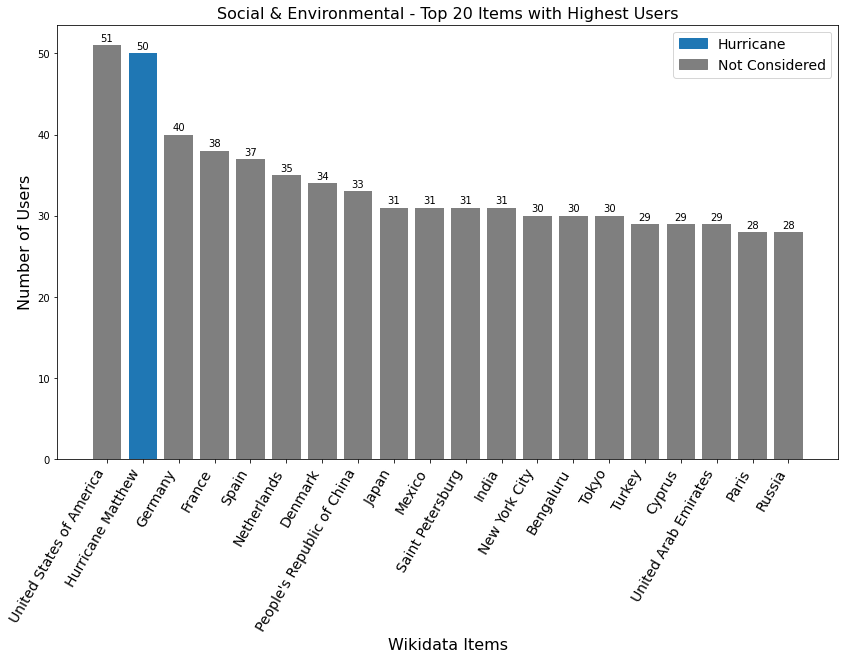

In [103]:
f, ax = plt.subplots(figsize=(14,8))

for i, r in enumerate(top20_users['userscount']):
    ax.text(i, r+0.5, str(r), horizontalalignment='center')


colours = ['tab:gray', 'tab:blue', 'tab:gray', 'tab:gray', 'tab:gray',
           'tab:gray', 'tab:gray', 'tab:gray', 'tab:gray', 'tab:gray',
           'tab:gray', 'tab:gray', 'tab:gray', 'tab:gray', 'tab:gray',
           'tab:gray', 'tab:gray', 'tab:gray', 'tab:gray', 'tab:gray']

hurricane = mpatches.Patch(color='tab:blue', label='Hurricane')
not_considered = mpatches.Patch(color='tab:gray', label='Not Considered')

plt.legend(handles=[hurricane, not_considered], fontsize=14)

plt.bar(top20_users['label'], top20_users['userscount'], color=colours)
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Users", fontsize=16)
plt.title("Social & Environmental - Top 20 Items with Highest Users", fontsize=16)

# Selecting Specific Items

This topic did not see a lot of items that could be considered. The following two items were chosen, as hurricane Mathew took place in 2016 and abortion which is usually a controversial topic.

- Hurricane Mathew - Environmental
- Abortion - Social

In [105]:
# Storing the revisions of the selected items in CSV files
# rev[rev['qid'] == 'Q27058656'].to_csv('/Users/tushi/PRJ/WikidataParsing/topics/selected_items/social_environmental/HurricaneMathew_Q27058656.csv')
# rev[rev['qid'] == 'Q8452'].to_csv('/Users/tushi/PRJ/WikidataParsing/topics/selected_items/social_environmental/abortion_Q8452.csv')